# Predicting faulty water pumps


## Background

This series of notebook will focus on a  predictive maintenance problem competition. The business challenge is brought by www.drivendata.org and the goal is to  predict the operation state (functional, repair needed, complete failure) of water pumps in Tanzania. The water pump data is provided by taarifa.org an organization that provides people the ability to report water and sanitation problems in Africa. Here is a dashboard of the status of water points in Tanzania: http://dashboard.taarifa.org/#/dashboard.</br>

## Business Objectives
Using data from Taarifa and the Tanzanian Ministry of Water, we will be trying to predict which pumps are functional, which need some repairs, and which don't work at all. Prediction will be based on on a number of variables:  what kind of pump is operating, when it was installed, and how it is managed etc. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania</br>

Reference: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table

# Data Cleaning & Feature Engineer¶

## Import Libraries
Import libraries necessary to get the exploratory data analysis (EDA) part of the project set-up

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
%matplotlib inline

Define a custom function which will impute null or missing values based on the highest occurance of these values for a specific slice of another feature  

In [36]:
# impute missing values based on the hightest occurence of this value in a seperate data slice
def impute_null_with_highest_frequency_value(df, impute_feature, frequency_feature):
    impute_cat_set = df[impute_feature].nunique()
    feat_cat_list = df[frequency_feature].unique()
    
    for i in feat_cat_list:
        feat_cat = train_features_df[df[frequency_feature] == i][impute_feature]  
        highest_feat_cat_occurence = df[frequency_feature].value_counts().idxmax()
        if sum(feat_cat.notnull()):
            highest_feat_cat_occurence = feat_cat.value_counts().idxmax()        
        print("Replacing {} feature null values: {} imputed by {}".format(impute_feature,i,highest_feat_cat_occurence))
        df[impute_feature].fillna(value=highest_feat_cat_occurence, inplace = True)
        
    # Sanity check for replaced null values
    assert impute_cat_set == df[impute_feature].nunique(), "impute_null_with_highest_frequency_value: null values replaced assert failed"

## Load Water Pump Data Frames

Read in the data pump files stored in the directory raw-data into Pandas dataframes

In [37]:
!dir raw-data\*.pkl

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\Udacity\machine-learning\projects\capstone-project\raw-data

05/31/2018  12:20 PM         3,634,926 pump_test_features_df.pkl
05/31/2018  12:20 PM        14,615,910 pump_train_features_df.pkl
05/31/2018  12:20 PM           594,995 pump_train_label_df.pkl
               3 File(s)     18,845,831 bytes
               0 Dir(s)  1,928,202,788,864 bytes free


In [38]:
train_features_df = pd.read_pickle('raw-data\pump_train_features_df.pkl')
train_label_df = pd.read_pickle('raw-data\pump_train_label_df.pkl')
test_features_df = pd.read_pickle('raw-data\pump_test_features_df.pkl')
print("Confirm shapes of the train and test dataframes:",train_features_df.shape, train_label_df.shape, test_features_df.shape)

('Confirm shapes of the train and test dataframes:', (59400, 40), (59400, 2), (14850, 40))


## Clean the data

### Standardise all string categorical values to lower case

In [39]:
# retrieve categorical variable
categorical_cols = train_features_df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = categorical_cols[1:] #exclude dates
categorical_cols.remove('permit') # exclude boolean feature
categorical_cols.remove('public_meeting')  # exclude boolean feature
print(categorical_cols)

['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [40]:
# Normalise string categorical to lower case except for boolean features: permit and public_meeting
for i in categorical_cols:
    train_features_df[i] = train_features_df[i].str.lower()

# Visualy check that the categorical variables are all lower case
train_features_df[categorical_cols].head()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,recorded_by,scheme_management,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,roman,roman,none,lake nyasa,mnyusi b,iringa,ludewa,mundindi,geodata consultants ltd,vwc,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,grumeti,grumeti,zahanati,lake victoria,nyamara,mara,serengeti,natta,geodata consultants ltd,other,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,lottery club,world vision,kwa mahundi,pangani,majengo,manyara,simanjiro,ngorika,geodata consultants ltd,vwc,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,unicef,unicef,zahanati ya nanyumbu,ruvuma / southern coast,mahakamani,mtwara,nanyumbu,nanyumbu,geodata consultants ltd,vwc,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,action in a,artisan,shuleni,lake victoria,kyanyamisa,kagera,karagwe,nyakasimbi,geodata consultants ltd,NaN,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### Inpute missing values
We've previously seen that the following features have NaN values that we will drop or impute: <br/> <br/>

<B> Nan/Null values count by feature: </B>

* scheme_name:              28166
* scheme_management:         3877
* installer:                 3655
* funder:                    3635
* public_meeting:            3334
* permit:                    3056
* subvillage:                 371

#### Address pump funder and installer missing values
* funder - Who funded the well 
* installer - Organization that installed the well

In [41]:
train_features_df['funder'].value_counts().head()

government of tanzania    9084
danida                    3114
hesawa                    2202
rwssp                     1374
world bank                1349
Name: funder, dtype: int64

In [42]:
train_features_df['installer'].value_counts().head()

dwe           17405
government     1891
hesawa         1395
rwe            1206
commu          1065
Name: installer, dtype: int64

In [43]:
# replace missing values from the funder feature with the highest occurence of funders
highest_funder_occurence = train_features_df['funder'].value_counts().idxmax()
train_features_df['funder'].fillna(value=highest_funder_occurence, inplace = True)
train_features_df['installer'].value_counts().head()

dwe           17405
government     1891
hesawa         1395
rwe            1206
commu          1065
Name: installer, dtype: int64

In [44]:
# Replace the missing values of the installer feature with with the highest occurence of installers for VWC management schemes 
highest_installer_occurence = train_features_df['funder'].value_counts().idxmax()
train_features_df['installer'].fillna(value=highest_installer_occurence, inplace = True)

In [45]:
# Check no null values left for funder and installer features
total_null_values = sum(train_features_df['funder'].isnull()) + sum(train_features_df['installer'].isnull())
assert total_null_values == 0, "Features: funder & installer - missing values replacement assert failed"

#### Address pump scheme_name & scheme_management missing values
* scheme_management - Who operates the waterpoint
* scheme_name - Who operates the waterpoint

In [46]:
# drop scheme_management feature: too many missing values
print(train_features_df['scheme_name'].unique())
train_features_df.drop('scheme_name', axis =1, inplace = True)

['roman' nan 'nyumba ya mungu pipe scheme' ... 'bl nsherehehe'
 'magati  gravity spri' 'mtawanya']


In [47]:
# replace scheme_management feature missing values by highest occurence for each funder category
impute_null_with_highest_frequency_value(train_features_df, 'scheme_management', 'funder')

Replacing scheme_management feature null values: roman imputed by vwc
Replacing scheme_management feature null values: grumeti imputed by wug
Replacing scheme_management feature null values: lottery club imputed by vwc
Replacing scheme_management feature null values: unicef imputed by vwc
Replacing scheme_management feature null values: action in a imputed by vwc
Replacing scheme_management feature null values: mkinga distric coun imputed by vwc
Replacing scheme_management feature null values: dwsp imputed by wug
Replacing scheme_management feature null values: rwssp imputed by wug
Replacing scheme_management feature null values: wateraid imputed by vwc
Replacing scheme_management feature null values: isingiro ho imputed by vwc
Replacing scheme_management feature null values: private imputed by private operator
Replacing scheme_management feature null values: danida imputed by vwc
Replacing scheme_management feature null values: world vision imputed by vwc
Replacing scheme_management f

Replacing scheme_management feature null values: go imputed by vwc
Replacing scheme_management feature null values: cdtf imputed by vwc
Replacing scheme_management feature null values: shawasa imputed by vwc
Replacing scheme_management feature null values: un imputed by vwc
Replacing scheme_management feature null values: awf imputed by vwc
Replacing scheme_management feature null values: commu imputed by vwc
Replacing scheme_management feature null values: community imputed by vwc
Replacing scheme_management feature null values: save the rain usa imputed by wua
Replacing scheme_management feature null values: kibara foundation imputed by parastatal
Replacing scheme_management feature null values: tlc imputed by vwc
Replacing scheme_management feature null values: rc churc imputed by vwc
Replacing scheme_management feature null values: plan int imputed by vwc
Replacing scheme_management feature null values: w.b imputed by vwc
Replacing scheme_management feature null values: lvia impute

Replacing scheme_management feature null values: mbiuwasa imputed by water board
Replacing scheme_management feature null values: the isla imputed by vwc
Replacing scheme_management feature null values: rotary club imputed by wua
Replacing scheme_management feature null values: muslims imputed by water authority
Replacing scheme_management feature null values: care international imputed by wug
Replacing scheme_management feature null values: kimkuma imputed by vwc
Replacing scheme_management feature null values: tanesco imputed by private operator
Replacing scheme_management feature null values: mbozi district council imputed by vwc
Replacing scheme_management feature null values: dasip imputed by vwc
Replacing scheme_management feature null values: tltc imputed by vwc
Replacing scheme_management feature null values: sdg imputed by wug
Replacing scheme_management feature null values: hsw imputed by vwc
Replacing scheme_management feature null values: mwaya mn imputed by wua
Replacing s

Replacing scheme_management feature null values: pmo imputed by wug
Replacing scheme_management feature null values: tuwasa imputed by other
Replacing scheme_management feature null values: irish ai imputed by vwc
Replacing scheme_management feature null values: mdrdp imputed by vwc
Replacing scheme_management feature null values: jeshi la wokovu imputed by vwc
Replacing scheme_management feature null values: government /tassaf imputed by vwc
Replacing scheme_management feature null values: mboma imputed by vwc
Replacing scheme_management feature null values: people from japan imputed by vwc
Replacing scheme_management feature null values: kilindi district co imputed by vwc
Replacing scheme_management feature null values: shamte said imputed by private operator
Replacing scheme_management feature null values: auwasa imputed by water authority
Replacing scheme_management feature null values: kidp imputed by water authority
Replacing scheme_management feature null values: tridep imputed 

Replacing scheme_management feature null values: redep imputed by vwc
Replacing scheme_management feature null values: kiwanda cha samaki imputed by vwc
Replacing scheme_management feature null values: singida yetu imputed by wug
Replacing scheme_management feature null values: rwsp imputed by wug
Replacing scheme_management feature null values: moravian imputed by vwc
Replacing scheme_management feature null values: sema s imputed by wug
Replacing scheme_management feature null values: cbhi imputed by vwc
Replacing scheme_management feature null values: tcrs /care imputed by water authority
Replacing scheme_management feature null values: makonde imputed by water board
Replacing scheme_management feature null values: millenium imputed by vwc
Replacing scheme_management feature null values: swisland/mount meru flowers imputed by vwc
Replacing scheme_management feature null values: kigoma municipal imputed by vwc
Replacing scheme_management feature null values: kinapa imputed by vwc
Rep

Replacing scheme_management feature null values: menon imputed by vwc
Replacing scheme_management feature null values: wate aid/sema imputed by vwc
Replacing scheme_management feature null values: dwe/ubalozi wa marekani imputed by parastatal
Replacing scheme_management feature null values: vifafi imputed by parastatal
Replacing scheme_management feature null values: cdg imputed by wug
Replacing scheme_management feature null values: kwasenenge group imputed by vwc
Replacing scheme_management feature null values: ded/rwssp imputed by vwc
Replacing scheme_management feature null values: oldonyolengai imputed by vwc
Replacing scheme_management feature null values: none imputed by other
Replacing scheme_management feature null values: village community imputed by wua
Replacing scheme_management feature null values: minjingu imputed by vwc
Replacing scheme_management feature null values: el imputed by vwc
Replacing scheme_management feature null values: d imputed by vwc
Replacing scheme_ma

Replacing scheme_management feature null values: h/w imputed by vwc
Replacing scheme_management feature null values: tanap imputed by vwc
Replacing scheme_management feature null values: roman cathoric church imputed by vwc
Replacing scheme_management feature null values: rombo dalta imputed by company
Replacing scheme_management feature null values: ilwilo community imputed by vwc
Replacing scheme_management feature null values: un/wfp imputed by parastatal
Replacing scheme_management feature null values: st ph imputed by vwc
Replacing scheme_management feature null values: lwiji italy imputed by vwc
Replacing scheme_management feature null values: livin imputed by vwc
Replacing scheme_management feature null values: cg imputed by parastatal
Replacing scheme_management feature null values: hhesawa imputed by vwc
Replacing scheme_management feature null values: lwi & central government imputed by wug
Replacing scheme_management feature null values: lc imputed by vwc
Replacing scheme_ma

Replacing scheme_management feature null values: ester ndege imputed by other
Replacing scheme_management feature null values: oikos e .africa/european union imputed by water board
Replacing scheme_management feature null values: nyabarongo kegoro imputed by other
Replacing scheme_management feature null values: quik imputed by vwc
Replacing scheme_management feature null values: ringo imputed by private operator
Replacing scheme_management feature null values: kanisani imputed by vwc
Replacing scheme_management feature null values: wfp/usaid/tnt imputed by parastatal
Replacing scheme_management feature null values: village council/ haydom luther imputed by vwc
Replacing scheme_management feature null values: fpct church imputed by water authority
Replacing scheme_management feature null values: mzung imputed by vwc
Replacing scheme_management feature null values: kwikwiz imputed by water authority
Replacing scheme_management feature null values: kanisa la mitume imputed by vwc
Replaci

Replacing scheme_management feature null values: vifaf imputed by parastatal
Replacing scheme_management feature null values: mtc imputed by vwc
Replacing scheme_management feature null values: lungwe imputed by private operator
Replacing scheme_management feature null values: dhinu imputed by vwc
Replacing scheme_management feature null values: aic kij imputed by vwc
Replacing scheme_management feature null values: mataro imputed by other
Replacing scheme_management feature null values: dagida imputed by vwc
Replacing scheme_management feature null values: redap imputed by other
Replacing scheme_management feature null values: nwssp imputed by wug
Replacing scheme_management feature null values: lench imputed by vwc
Replacing scheme_management feature null values: wanakijiji imputed by vwc
Replacing scheme_management feature null values: nk imputed by vwc
Replacing scheme_management feature null values: nimrodi mkono[mb] imputed by parastatal
Replacing scheme_management feature null v

Replacing scheme_management feature null values: japan food aid imputed by vwc
Replacing scheme_management feature null values: d ct imputed by vwc
Replacing scheme_management feature null values: diocese of mount kilimanjaro imputed by vwc
Replacing scheme_management feature null values: health  ministry imputed by vwc
Replacing scheme_management feature null values: vickfis imputed by vwc
Replacing scheme_management feature null values: isf / tasaff imputed by vwc
Replacing scheme_management feature null values: serian imputed by vwc
Replacing scheme_management feature null values: roman cathoric imputed by vwc
Replacing scheme_management feature null values: chacha issame imputed by other
Replacing scheme_management feature null values: villege council imputed by vwc
Replacing scheme_management feature null values: kilimarondo parish imputed by trust
Replacing scheme_management feature null values: tempo imputed by vwc
Replacing scheme_management feature null values: mboni salehe im

Replacing scheme_management feature null values: longido sec school imputed by parastatal
Replacing scheme_management feature null values: piscop imputed by vwc
Replacing scheme_management feature null values: mwl. nyerere sec. school imputed by vwc
Replacing scheme_management feature null values: ox imputed by vwc
Replacing scheme_management feature null values: domestic water supply project imputed by wug
Replacing scheme_management feature null values: church of disciples imputed by vwc
Replacing scheme_management feature null values: oikos imputed by parastatal
Replacing scheme_management feature null values: samweli kitana imputed by other
Replacing scheme_management feature null values: parastatal an imputed by private operator
Replacing scheme_management feature null values: marumbo community imputed by vwc
Replacing scheme_management feature null values: ju imputed by wug
Replacing scheme_management feature null values: patuu imputed by vwc
Replacing scheme_management feature n

Replacing scheme_management feature null values: laramatak imputed by private operator
Replacing scheme_management feature null values: tasaf and mmem imputed by vwc
Replacing scheme_management feature null values: saleh zaharani imputed by private operator
Replacing scheme_management feature null values: mwalimu  maneromango muhenzi imputed by private operator
Replacing scheme_management feature null values: mamaz imputed by other
Replacing scheme_management feature null values: heri mission imputed by water authority
Replacing scheme_management feature null values: mhuzu imputed by private operator
Replacing scheme_management feature null values: misri government imputed by vwc
Replacing scheme_management feature null values: kombe foundation imputed by wug
Replacing scheme_management feature null values: nyamuhanga maro imputed by other
Replacing scheme_management feature null values: japan food imputed by vwc
Replacing scheme_management feature null values: german missionary impute

Replacing scheme_management feature null values: seif ndago imputed by private operator
Replacing scheme_management feature null values: germany cristians imputed by vwc
Replacing scheme_management feature null values: juhibu imputed by vwc
Replacing scheme_management feature null values: irevea sister imputed by vwc
Replacing scheme_management feature null values: dqnida imputed by wug
Replacing scheme_management feature null values: sweeden imputed by private operator
Replacing scheme_management feature null values: kerebuka imputed by company
Replacing scheme_management feature null values: dom imputed by vwc
Replacing scheme_management feature null values: school adm9nstrarion imputed by vwc
Replacing scheme_management feature null values: friend from un imputed by wua
Replacing scheme_management feature null values: if imputed by vwc
Replacing scheme_management feature null values: motiba wambura imputed by other
Replacing scheme_management feature null values: f imputed by vwc
Re

Replacing scheme_management feature null values: tlc/community imputed by vwc
Replacing scheme_management feature null values: tanzania journey imputed by parastatal
Replacing scheme_management feature null values: q-sem ltd imputed by vwc
Replacing scheme_management feature null values: motiba manyanya imputed by other
Replacing scheme_management feature null values: siss m. minghetti imputed by vwc
Replacing scheme_management feature null values: mdgwc imputed by parastatal
Replacing scheme_management feature null values: meco imputed by vwc
Replacing scheme_management feature null values: neemia mission imputed by private operator
Replacing scheme_management feature null values: incerto imputed by vwc
Replacing scheme_management feature null values: rashid seng'ombe imputed by private operator
Replacing scheme_management feature null values: rafik imputed by vwc
Replacing scheme_management feature null values: kondo primary imputed by company
Replacing scheme_management feature null

Replacing scheme_management feature null values: makondakonde water population imputed by vwc
Replacing scheme_management feature null values: hassan gulam imputed by vwc
Replacing scheme_management feature null values: overnment imputed by water authority
Replacing scheme_management feature null values: nazareth church imputed by vwc
Replacing scheme_management feature null values: rv imputed by vwc
Replacing scheme_management feature null values: ramsar imputed by vwc
Replacing scheme_management feature null values: scholastica pankrasi imputed by other
Replacing scheme_management feature null values: zao water spring imputed by vwc
Replacing scheme_management feature null values: national park imputed by vwc
Replacing scheme_management feature null values: member of perliament ahmed ali imputed by wug
Replacing scheme_management feature null values: tadeo imputed by vwc
Replacing scheme_management feature null values: theo imputed by vwc
Replacing scheme_management feature null valu

Replacing scheme_management feature null values: rc mi imputed by vwc
Replacing scheme_management feature null values: luke samaras ltd imputed by vwc
Replacing scheme_management feature null values: icap imputed by vwc
Replacing scheme_management feature null values: winkyens imputed by vwc
Replacing scheme_management feature null values: deogratius kasima imputed by vwc
Replacing scheme_management feature null values: muhindi imputed by vwc
Replacing scheme_management feature null values: sumriy imputed by parastatal
Replacing scheme_management feature null values: kwang-nam middle-school imputed by vwc
Replacing scheme_management feature null values: samweli imputed by private operator
Replacing scheme_management feature null values: waitaliano imputed by private operator
Replacing scheme_management feature null values: robert kampala imputed by vwc
Replacing scheme_management feature null values: tasaf/tlc imputed by vwc
Replacing scheme_management feature null values: mhina impute

Replacing scheme_management feature null values: matata selemani imputed by vwc
Replacing scheme_management feature null values: wdsp imputed by wug
Replacing scheme_management feature null values: game fronti imputed by vwc
Replacing scheme_management feature null values: dmd imputed by vwc
Replacing scheme_management feature null values: soko la magomeni imputed by wug
Replacing scheme_management feature null values: yasini imputed by private operator
Replacing scheme_management feature null values: district medical imputed by vwc
Replacing scheme_management feature null values: nipon & panoco imputed by wug
Replacing scheme_management feature null values: ddca imputed by vwc
Replacing scheme_management feature null values: jumaa imputed by private operator
Replacing scheme_management feature null values: silinda yetu imputed by wug
Replacing scheme_management feature null values: babtist imputed by vwc
Replacing scheme_management feature null values: the islamic imputed by vwc
Repla

Replacing scheme_management feature null values: cida imputed by vwc
Replacing scheme_management feature null values: dwe/anglican church imputed by vwc
Replacing scheme_management feature null values: dina imputed by other
Replacing scheme_management feature null values: brown imputed by vwc
Replacing scheme_management feature null values: samlo imputed by vwc


In [48]:
# Check no null values left for funder and installer features
total_null_values = sum(train_features_df['scheme_management'].isnull())
assert total_null_values == 0, "Features: scheme_management - missing values replacement assert failed"

#### Address public_meeting and permit features missing values
* public_meeting - True/False
* permit - If the waterpoint is permitted

In [49]:
# replace public_meeting feature missing values by highest occurence - it is clearly True
train_features_df['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [50]:
train_features_df['public_meeting'].fillna(value=True, inplace = True) 
assert total_null_values == 0, "Features: public_meeting - missing values replacement assert failed"

In [51]:
# replace permit feature missing values is more tricky since it is distributed 1/3 for False and 2/3 for True
train_features_df['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [52]:
# replace scheme_management feature missing values by highest occurence for each installer category
impute_null_with_highest_frequency_value(train_features_df, 'permit', 'installer')

Replacing permit feature null values: roman imputed by False
Replacing permit feature null values: grumeti imputed by False
Replacing permit feature null values: world vision imputed by True
Replacing permit feature null values: unicef imputed by False
Replacing permit feature null values: artisan imputed by True
Replacing permit feature null values: dwe imputed by True
Replacing permit feature null values: dwsp imputed by True
Replacing permit feature null values: water aid imputed by True
Replacing permit feature null values: private imputed by False
Replacing permit feature null values: danida imputed by True
Replacing permit feature null values: lawatefuka water sup imputed by True
Replacing permit feature null values: wedeco imputed by True
Replacing permit feature null values: danid imputed by True
Replacing permit feature null values: twe imputed by False
Replacing permit feature null values: isf imputed by True
Replacing permit feature null values: kilolo star imputed by False


Replacing permit feature null values: safari roya imputed by True
Replacing permit feature null values: dawasco imputed by True
Replacing permit feature null values: gover imputed by True
Replacing permit feature null values: mission imputed by True
Replacing permit feature null values: dwe/ imputed by False
Replacing permit feature null values: halmashauri ya wilaya sikonge imputed by True
Replacing permit feature null values: ki imputed by True
Replacing permit feature null values: rhoda imputed by False
Replacing permit feature null values: hapa singida imputed by True
Replacing permit feature null values: consulting engineer imputed by False
Replacing permit feature null values: karugendo imputed by False
Replacing permit feature null values: co imputed by True
Replacing permit feature null values: marafip imputed by True
Replacing permit feature null values: cosmos eng ltd imputed by True
Replacing permit feature null values: world banks imputed by True
Replacing permit feature nu

Replacing permit feature null values: nice imputed by True
Replacing permit feature null values: cct imputed by False
Replacing permit feature null values: world vission imputed by False
Replacing permit feature null values: inter imputed by False
Replacing permit feature null values: dmmd imputed by True
Replacing permit feature null values: aqua blues angels imputed by True
Replacing permit feature null values: mack donald contractor imputed by False
Replacing permit feature null values: water aid /sema imputed by True
Replacing permit feature null values: henure dema imputed by True
Replacing permit feature null values: kirdep imputed by True
Replacing permit feature null values: adra/government imputed by True
Replacing permit feature null values: kilwater imputed by True
Replacing permit feature null values: villi imputed by False
Replacing permit feature null values: koyi imputed by True
Replacing permit feature null values: ad imputed by True
Replacing permit feature null values

Replacing permit feature null values: rwe/community imputed by True
Replacing permit feature null values: mileniam project imputed by True
Replacing permit feature null values: active tank co imputed by False
Replacing permit feature null values: africa islamic agency tanzania imputed by True
Replacing permit feature null values: max mbise imputed by True
Replacing permit feature null values: dads imputed by False
Replacing permit feature null values: institutional imputed by False
Replacing permit feature null values: sowasa imputed by True
Replacing permit feature null values: ccpk imputed by True
Replacing permit feature null values: australia imputed by True
Replacing permit feature null values: kalago enterprises co.ltd imputed by False
Replacing permit feature null values: roman catholic imputed by True
Replacing permit feature null values: nanra contractor imputed by False
Replacing permit feature null values: no imputed by True
Replacing permit feature null values: adp busangi 

Replacing permit feature null values: government /community imputed by False
Replacing permit feature null values: ccps imputed by True
Replacing permit feature null values: si imputed by True
Replacing permit feature null values: rundu man imputed by True
Replacing permit feature null values: naishu construction co. ltd imputed by True
Replacing permit feature null values: would bank imputed by True
Replacing permit feature null values: mark imputed by True
Replacing permit feature null values: cosmo imputed by False
Replacing permit feature null values: halmashauri imputed by True
Replacing permit feature null values: concern /government imputed by True
Replacing permit feature null values: quick win project imputed by True
Replacing permit feature null values: mh kapuya imputed by True
Replacing permit feature null values: halmashauri ya wilaya imputed by False
Replacing permit feature null values: edward imputed by True
Replacing permit feature null values: baric imputed by True
Re

Replacing permit feature null values: wdeco imputed by True
Replacing permit feature null values: livi imputed by False
Replacing permit feature null values: pet corporation ltd imputed by True
Replacing permit feature null values: dwe & lwi imputed by False
Replacing permit feature null values: lc imputed by True
Replacing permit feature null values: kkkt leguruki imputed by True
Replacing permit feature null values: hiap imputed by False
Replacing permit feature null values: matyenye imputed by False
Replacing permit feature null values: dimon imputed by True
Replacing permit feature null values: italy government imputed by False
Replacing permit feature null values: maswi drill imputed by True
Replacing permit feature null values: wvc imputed by True
Replacing permit feature null values: tacri imputed by True
Replacing permit feature null values: hasnein murij imputed by True
Replacing permit feature null values: simba lodge imputed by False
Replacing permit feature null values: fau

Replacing permit feature null values: norani imputed by False
Replacing permit feature null values: mahita imputed by True
Replacing permit feature null values: - imputed by True
Replacing permit feature null values: karumba biuldin imputed by True
Replacing permit feature null values: aixos imputed by True
Replacing permit feature null values: selikali imputed by True
Replacing permit feature null values: ddp imputed by True
Replacing permit feature null values: zacharia mtn imputed by False
Replacing permit feature null values: africa imputed by True
Replacing permit feature null values: pad imputed by True
Replacing permit feature null values: kashwa imputed by True
Replacing permit feature null values: twende pamoja imputed by True
Replacing permit feature null values: uhai wa mama na mtoto imputed by False
Replacing permit feature null values: olomoloki imputed by True
Replacing permit feature null values: ardhi water well imputed by False
Replacing permit feature null values: dis

Replacing permit feature null values: make engineering imputed by False
Replacing permit feature null values: halmashauri wilaya imputed by False
Replacing permit feature null values: chacha imputed by True
Replacing permit feature null values: efam imputed by True
Replacing permit feature null values: tasaf/ imputed by False
Replacing permit feature null values: mgaya imputed by True
Replacing permit feature null values: grail mission kiseki bar imputed by False
Replacing permit feature null values: rude imputed by False
Replacing permit feature null values: maji tech imputed by True
Replacing permit feature null values: jhl co ltd imputed by False
Replacing permit feature null values: ansnani murij imputed by True
Replacing permit feature null values: liuwassa imputed by True
Replacing permit feature null values: ustawi imputed by True
Replacing permit feature null values: german imputed by False
Replacing permit feature null values: nssf imputed by False
Replacing permit feature nul

Replacing permit feature null values: athumani  janguo imputed by False
Replacing permit feature null values: geita goldmain imputed by True
Replacing permit feature null values: greineker imputed by True
Replacing permit feature null values: tareto imputed by True
Replacing permit feature null values: teresa munyama imputed by True
Replacing permit feature null values: kkkt dme imputed by False
Replacing permit feature null values: maji mugumu imputed by True
Replacing permit feature null values: issa mohamedi tumwanga imputed by True
Replacing permit feature null values: morovian imputed by True
Replacing permit feature null values: american imputed by True
Replacing permit feature null values: anglican church imputed by True
Replacing permit feature null values: benguka imputed by False
Replacing permit feature null values: william acles imputed by True
Replacing permit feature null values: jackson makore imputed by True
Replacing permit feature null values: mr kwi imputed by True
R

Replacing permit feature null values: anglican uganda imputed by False
Replacing permit feature null values: ministry of education imputed by False
Replacing permit feature null values: centra govt imputed by True
Replacing permit feature null values: hesawz imputed by True
Replacing permit feature null values: b.a.p imputed by True
Replacing permit feature null values: r imputed by True
Replacing permit feature null values: nasan workers imputed by False
Replacing permit feature null values: twess imputed by False
Replacing permit feature null values: wizara  ya maji imputed by True
Replacing permit feature null values: water hu imputed by True
Replacing permit feature null values: kk imputed by True
Replacing permit feature null values: cip imputed by True
Replacing permit feature null values: monmali imputed by True
Replacing permit feature null values: dw$ imputed by True
Replacing permit feature null values: karumba biulding contractor imputed by False
Replacing permit feature nul

Replacing permit feature null values: billy phillips imputed by True
Replacing permit feature null values: wamissionari wa kikatoriki imputed by False
Replacing permit feature null values: kapelo imputed by False
Replacing permit feature null values: pnr da imputed by True
Replacing permit feature null values: tanz/egypt technical coopera imputed by True
Replacing permit feature null values: masjid nnre imputed by True
Replacing permit feature null values: ahmad imputed by True
Replacing permit feature null values: dydrotec imputed by True
Replacing permit feature null values: daniad imputed by False
Replacing permit feature null values: private technician imputed by True
Replacing permit feature null values: jackson mahambo imputed by False
Replacing permit feature null values: rombo dalta imputed by True
Replacing permit feature null values: jeshi la wokovu [cida] imputed by True
Replacing permit feature null values: mwita machoa imputed by True
Replacing permit feature null values: 

Replacing permit feature null values: mama hamisa imputed by False
Replacing permit feature null values: methodist church imputed by True
Replacing permit feature null values: george mtoto imputed by False
Replacing permit feature null values: dw e imputed by False
Replacing permit feature null values: jwtz imputed by False
Replacing permit feature null values: wajerumani imputed by False
Replacing permit feature null values: mama joela imputed by False
Replacing permit feature null values: tlc/community imputed by True
Replacing permit feature null values: world visiin imputed by False
Replacing permit feature null values: napupanga imputed by False
Replacing permit feature null values: grumet imputed by True
Replacing permit feature null values: q-sem ltd imputed by False
Replacing permit feature null values: motiba manyanya imputed by True
Replacing permit feature null values: meco imputed by True
Replacing permit feature null values: neemia mission imputed by True
Replacing permit 

Replacing permit feature null values: zao water spring imputed by True
Replacing permit feature null values: member of perliament ahmed ali imputed by True
Replacing permit feature null values: agrican imputed by True
Replacing permit feature null values: tadeo imputed by True
Replacing permit feature null values: theo imputed by False
Replacing permit feature null values: paskali imputed by False
Replacing permit feature null values: matiiti imputed by True
Replacing permit feature null values: shule ya sekondari ipuli imputed by True
Replacing permit feature null values: dokta mwandulami imputed by True
Replacing permit feature null values: adrs imputed by True
Replacing permit feature null values: mara inter product imputed by False
Replacing permit feature null values: tanzania/ egypt imputed by True
Replacing permit feature null values: water users group imputed by True
Replacing permit feature null values: mbuzi mawe imputed by False
Replacing permit feature null values: cristan 

Replacing permit feature null values: dv imputed by True
Replacing permit feature null values: region water imputed by False
Replacing permit feature null values: dhv moro imputed by True
Replacing permit feature null values: fpct church imputed by True
Replacing permit feature null values: rc njoro imputed by False
Replacing permit feature null values: kindoroko water project imputed by False
Replacing permit feature null values: mama kapwapwa imputed by True
Replacing permit feature null values: birage imputed by True
Replacing permit feature null values: kikom imputed by False
Replacing permit feature null values: udea imputed by False
Replacing permit feature null values: mambe imputed by True
Replacing permit feature null values: mwita mahiti imputed by True
Replacing permit feature null values: danids imputed by True
Replacing permit feature null values: h4ccp imputed by True
Replacing permit feature null values: anglikan imputed by True
Replacing permit feature null values: vill

Replacing permit feature null values: joery magabe imputed by False
Replacing permit feature null values: gesine imputed by False
Replacing permit feature null values: mwita lucas imputed by True
Replacing permit feature null values: hamis makombo imputed by True
Replacing permit feature null values: bumabu imputed by False
Replacing permit feature null values: manyovu agriculture institute imputed by False
Replacing permit feature null values: serens imputed by False
Replacing permit feature null values: gerald mila imputed by True
Replacing permit feature null values: natio imputed by True
Replacing permit feature null values: simango kihengu imputed by True
Replacing permit feature null values: m imputed by True
Replacing permit feature null values: heesaw imputed by True
Replacing permit feature null values: goldmain imputed by True
Replacing permit feature null values: m and p imputed by True
Replacing permit feature null values: masu company imputed by True
Replacing permit featu

In [53]:
# Check no null values left for the permit feature
total_null_values = sum(train_features_df['permit'].isnull())
total_null_values
#assert total_null_values == 0, "Features: permit  - missing values replacement assert failed"

0

#### Address subvillage feature missing values
* subvillage - Geographic location

Inspect null values for the subvillage feature

In [54]:
train_features_df[train_features_df['subvillage'].isnull()]['region'].value_counts()

dodoma    361
mwanza     10
Name: region, dtype: int64

We observe that the null values for subvillage are located in two specific Tanzania regions: dodoma, mwanza

In [55]:
# replace subvillage feature missing values by highest occurence for each region category
impute_null_with_highest_frequency_value(train_features_df, 'subvillage', 'region')

Replacing subvillage feature null values: iringa imputed by m
Replacing subvillage feature null values: mara imputed by senta
Replacing subvillage feature null values: manyara imputed by madukani
Replacing subvillage feature null values: mtwara imputed by majengo
Replacing subvillage feature null values: kagera imputed by bunukangoma
Replacing subvillage feature null values: tanga imputed by sokoni
Replacing subvillage feature null values: shinyanga imputed by madukani
Replacing subvillage feature null values: tabora imputed by majengo
Replacing subvillage feature null values: pwani imputed by vikuge
Replacing subvillage feature null values: ruvuma imputed by muungano
Replacing subvillage feature null values: kilimanjaro imputed by majengo
Replacing subvillage feature null values: rukwa imputed by majengo
Replacing subvillage feature null values: mwanza imputed by 1
Replacing subvillage feature null values: kigoma imputed by majengo
Replacing subvillage feature null values: lindi imput

In [56]:
# Check no null values left for subvillage features
total_null_values = sum(train_features_df['subvillage'].isnull())
assert total_null_values == 0, "Features: subvillage - missing values replacement assert failed"

### Validate that all missing values have been imputed or dropped 

In [57]:
# Check if the training set has any missing values
num_null_val = train_features_df.isnull().sum().sort_values(ascending=False).head(10)
num_null_val

waterpoint_type_group    0
num_private              0
ward                     0
lga                      0
district_code            0
region_code              0
region                   0
subvillage               0
basin                    0
wpt_name                 0
dtype: int64

In [58]:
train_features_df.shape

(59400, 39)

## Feature engineering

#### Compute the age of the pumps based on the construction_year
The age of the pump will likely be a better predictor of a pump failure than the year it was constructed. <br/>
We will compute the age of the pumps at the time the data set observations were recorded

In [59]:
# Inspect construction_year feature
train_features_df['construction_year'].head()

0    1999
1    2010
2    2009
3    1986
4       0
Name: construction_year, dtype: int64

In [60]:
print("Construction year: min, max:",train_features_df['construction_year'].min(), train_features_df['construction_year'].max())
print("Number of invalid construction year values:", sum(train_features_df['construction_year'] == 0))

('Construction year: min, max:', 0, 2013)
('Number of invalid construction year values:', 20709)


More than 20000 pumps or 1/3 of our training data have invalid construction_year values (i.e. 0) and these values need to be imputed 

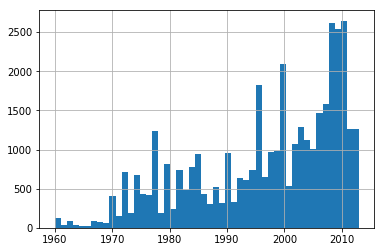

In [61]:
# Inspect the distribution of valid construction years (ie. not 0)
valid_construction_year_df = train_features_df[train_features_df['construction_year'] > 0]
valid_construction_year_df['construction_year'].hist(bins = 50)

In [62]:
# Compute the median contruction_year for pumps
median_construction_year_value=int(valid_construction_year_df['construction_year'].median())
median_construction_year_value

2000

In [63]:
# replace the 0 values in the construction_year by the median year
train_features_df['construction_year'].replace(0, median_construction_year_value,inplace=True)
print("Construction year: min, max:",train_features_df['construction_year'].min(), train_features_df['construction_year'].max())

('Construction year: min, max:', 1960, 2013)


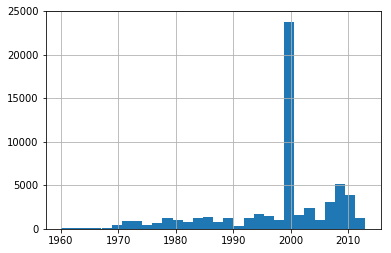

In [64]:
train_features_df['construction_year'].hist(bins = 30)

In [65]:
# Inspect date_recorded feature
train_features_df['date_recorded'].head()

0    2011-03-14
1    2013-03-06
2    2013-02-25
3    2013-01-28
4    2011-07-13
Name: date_recorded, dtype: object

In [66]:
# Extract the of date_recorded feature and create a new feature: year_recorded
def extract_year(date):
    return (int(date.split('-')[0]))

train_features_df['year_recorded'] = train_features_df['date_recorded'].apply(extract_year)
train_features_df['year_recorded'].head()

0    2011
1    2013
2    2013
3    2013
4    2011
Name: year_recorded, dtype: int64

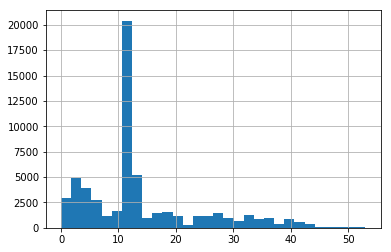

In [67]:
# Compute the age of each pump, we will drop the construction_year and date_recorded features later
train_features_df['pump_age'] = abs(train_features_df['construction_year'] - train_features_df['year_recorded'])
train_features_df['pump_age'].hist(bins = 30)

#### Transform the GPS location features

Tanzania is divided in water basin areas and this is likely relevant information for the prediction of the pump status 

In [68]:
basin_list = train_features_df['basin'].unique()
train_features_df['basin'].value_counts()

lake victoria              10248
pangani                     8940
rufiji                      7976
internal                    7785
lake tanganyika             6432
wami / ruvu                 5987
lake nyasa                  5085
ruvuma / southern coast     4493
lake rukwa                  2454
Name: basin, dtype: int64

![Tanzania Water Basin](https://www.researchgate.net/publication/312373453/figure/fig1/AS:471438105812994@1489411011502/Map-of-the-nine-River-Basin-Offices-in-Tanzania.png)

In [69]:
basin_list

array(['lake nyasa', 'lake victoria', 'pangani',
       'ruvuma / southern coast', 'internal', 'lake tanganyika',
       'wami / ruvu', 'rufiji', 'lake rukwa'], dtype=object)

The GPS information of each pump is available in the following data set features:
* gps_height - Altitude of the well
* longitude - GPS coordinate 
* latitude - GPS coordinate 

In [70]:
# Inspect the GPS features and stats profile
gps_feature_list = ['gps_height', 'longitude', 'latitude']
train_features_df[gps_feature_list].describe()

,gps_height,longitude,latitude
count,59400.000000,59400.000000,5.940000e+04
mean,668.297239,34.077427,-5.706033e+00
std,693.116350,6.567432,2.946019e+00
min,-90.000000,0.000000,-1.164944e+01
25%,0.000000,33.090347,-8.540621e+00
50%,369.000000,34.908743,-5.021597e+00
75%,1319.250000,37.178387,-3.326156e+00
max,2770.000000,40.345193,-2.000000e-08


We notice that some of these GPS value are invalid (e.g. negative altitude) as Tanzania has the following GPS bounderies:
* height > 0
* latitude: between 0S and -12S
* longitude: between 30E and 40E </br>
    
Source: https://www.mapsofworld.com/lat_long/tanzania-lat-long.html

We can clean-up the obvious wrong gps location by taking the mean of these for each basin observation

In [71]:
# Approximate GPS bounderies for Tanzania
lat_min = -12 
lat_max = 0
lon_min = 30
lon_max = 40
height_min = 0

correct_gps_df = train_features_df[
    (train_features_df['latitude'] > lat_min ) & (train_features_df['latitude'] < lat_max) & \
    (train_features_df['longitude'] > lon_min  ) & (train_features_df['longitude'] < lon_max) & \
    (train_features_df['gps_height'] > height_min) ]

# mean of gps data in each Tanzanian basin
mean_correct_gps_df = correct_gps_df.groupby(['basin'])['latitude','longitude','gps_height'].mean()
mean_correct_gps_df

,latitude,longitude,gps_height
basin,,,
internal,-4.160205,34.949760,885.677328
lake nyasa,-9.704374,34.247699,796.058407
lake rukwa,-8.277140,32.377660,583.585575
lake tanganyika,-4.579051,31.487778,649.616893
lake victoria,-2.241567,32.760710,394.340832
pangani,-3.897671,37.597019,1053.689628
rufiji,-8.422199,35.681446,922.878855
ruvuma / southern coast,-10.549789,38.096090,466.833881
wami / ruvu,-6.571672,37.764122,230.074054


In [117]:
#z = foo['x'].where(foo['Country'] == 'USA', foo['y'])
for i in basin_list:
    print(i)
    print(train_features_df[(train_features_df['longitude'] < lon_min) | \
          (train_features_df['longitude'] > lon_max)].where(train_features_df['basin'] == i))

lake nyasa
       id  amount_tsh date_recorded funder  gps_height installer  longitude  \
21    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
24    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
53    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
62    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
69    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
90    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
154   NaN         NaN           NaN    NaN         NaN       NaN        NaN   
168   NaN         NaN           NaN    NaN         NaN       NaN        NaN   
177   NaN         NaN           NaN    NaN         NaN       NaN        NaN   
223   NaN         NaN           NaN    NaN         NaN       NaN        NaN   
253   NaN         NaN           NaN    NaN         NaN       NaN        NaN   
256   NaN         NaN           NaN    Na

            id  amount_tsh date_recorded                  funder  gps_height  \
21      6091.0         0.0    2013-02-10                    dwsp         0.0   
24         NaN         NaN           NaN                     NaN         NaN   
53     32376.0         0.0    2011-08-01  government of tanzania         0.0   
62         NaN         NaN           NaN                     NaN         NaN   
69         NaN         NaN           NaN                     NaN         NaN   
90         NaN         NaN           NaN                     NaN         NaN   
154        NaN         NaN           NaN                     NaN         NaN   
168    72678.0         0.0    2013-01-30                     wvt         0.0   
177    56725.0         0.0    2013-01-17             netherlands         0.0   
223        NaN         NaN           NaN                     NaN         NaN   
253    13042.0         0.0    2012-10-29                  hesawa         0.0   
256    33500.0         0.0    2011-07-18

            id  amount_tsh date_recorded                       funder  \
21         NaN         NaN           NaN                          NaN   
24         NaN         NaN           NaN                          NaN   
53         NaN         NaN           NaN                          NaN   
62         NaN         NaN           NaN                          NaN   
69         NaN         NaN           NaN                          NaN   
90         NaN         NaN           NaN                          NaN   
154        NaN         NaN           NaN                          NaN   
168        NaN         NaN           NaN                          NaN   
177        NaN         NaN           NaN                          NaN   
223        NaN         NaN           NaN                          NaN   
253        NaN         NaN           NaN                          NaN   
256        NaN         NaN           NaN                          NaN   
285        NaN         NaN           NaN           

[3172 rows x 41 columns]
wami / ruvu
       id  amount_tsh date_recorded funder  gps_height installer  longitude  \
21    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
24    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
53    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
62    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
69    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
90    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
154   NaN         NaN           NaN    NaN         NaN       NaN        NaN   
168   NaN         NaN           NaN    NaN         NaN       NaN        NaN   
177   NaN         NaN           NaN    NaN         NaN       NaN        NaN   
223   NaN         NaN           NaN    NaN         NaN       NaN        NaN   
253   NaN         NaN           NaN    NaN         NaN       NaN        NaN   
256   NaN      

       id  amount_tsh date_recorded funder  gps_height installer  longitude  \
21    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
24    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
53    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
62    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
69    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
90    NaN         NaN           NaN    NaN         NaN       NaN        NaN   
154   NaN         NaN           NaN    NaN         NaN       NaN        NaN   
168   NaN         NaN           NaN    NaN         NaN       NaN        NaN   
177   NaN         NaN           NaN    NaN         NaN       NaN        NaN   
223   NaN         NaN           NaN    NaN         NaN       NaN        NaN   
253   NaN         NaN           NaN    NaN         NaN       NaN        NaN   
256   NaN         NaN           NaN    NaN         N

In [100]:
# select gps values that are likely invalid or faulty
for i in basin_list:
    train_features_df[(((train_features_df['latitude'] < lat_min ) | \
                    (train_features_df['latitude'] > lat_max)) & \
                      train_features_df['basin'] == i)]['latitude'] = mean_correct_gps_df.loc[i, 'latitude']

TypeError: invalid type comparison

In [98]:
    train_features_df[(train_features_df['longitude'] < lon_min ) | \
                    (train_features_df['longitude'] > lon_max)].loc[i,'longitude'] = mean_correct_gps_df.loc[i, 'longitude']

    train_features_df[(train_features_df['gps_height'] < height_min)].loc[i,'gps_height'] = mean_correct_gps_df.loc[i, 'gps_height']  
for i in basin_list:
    train_features_df[(train_features_df['gps_height'] < height_min)]

KeyError: 'lake nyasa'

In [72]:
# replace gps values that are likely invalid or faulty                                      
for i in basin_list:
    invalid_gps_lat_df.loc[i]['latitude'] = mean_correct_gps_df.loc[i, 'latitude']
    invalid_gps_lon_df.loc[i]['longitude'] = mean_correct_gps_df.loc[i, 'longitude']
    invalid_gps_height_df[i]['gps_height'] = mean_correct_gps_df.loc[i, 'gps_height']      

NameError: name 'invalid_gps_lat_df' is not defined

#### Remove likely irrelevant features
Some fatures likely have little correlation with the business outcome (pump failure prediction) and labels 
In particular, we will drop the following features:
* date_recorded - The date the row was entered
* num_private - no definitions provided

In [ ]:
# drop scheme_management feature: too many missing values
train_features_df.drop(['date_recorded', 'num_private', 'construction_year'], axis =1, inplace = True)
train_features_df.shape

In [40]:
# set up the data frames that we will be using to perform EDA 
train_features_df = df_list[0]
train_label_df = df_list[1]
test_features_df = df_list[2] 
print("Confirm shapes of the train and test dataframes:",train_features_df.shape, train_label_df.shape, test_features_df.shape)

('Confirm shapes of the train and test dataframes:', (59400, 40), (59400, 2), (14850, 40))


In [53]:
# Look at the first few rows of the data set
train_features_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


## Exploration of Features

Below is a data disctionary provided (source: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/)
* amount_tsh - Total static head (amount water available to waterpoint) <br/>
* date_recorded - The date the row was entered <br/>
* funder - Who funded the well <br/>
* gps_height - Altitude of the well<br/>
* installer - Organization that installed the well<br/>
* longitude - GPS coordinate <br/>
* latitude - GPS coordinate <br/>
* wpt_name - Name of the waterpoint if there is one <br/>
* num_private -
* basin - Geographic water basin<br/>
* subvillage - Geographic location<br/>
* region - Geographic location<br/>
* region_code - Geographic location (coded)<br/>
* district_code - Geographic location (coded)<br/>
* lga - Geographic location<br/>
* ward - Geographic location<br/>
* population - Population around the well<br/>
* public_meeting - True/False<br/>
* recorded_by - Group entering this row of data<br/>
* scheme_management - Who operates the waterpoint<br/>
* scheme_name - Who operates the waterpoint<br/>
* permit - If the waterpoint is permitted<br/>
* construction_year - Year the waterpoint was constructed<br/>
* extraction_type - The kind of extraction the waterpoint uses<br/>
* extraction_type_group - The kind of extraction the waterpoint uses<br/>
* extraction_type_class - The kind of extraction the waterpoint uses<br/>
* management - How the waterpoint is managed<br/>
* management_group - How the waterpoint is managed<br/>
* payment - What the water costs<br/>
* payment_type - What the water costs<br/>
* water_quality - The quality of the water<br/>
* quality_group - The quality of the water<br/>
* quantity - The quantity of water<br/>
* quantity_group - The quantity of water<br/>
* source - The source of the water<br/>
* source_type - The source of the water<br/>
* source_class - The source of the water<br/>
* waterpoint_type - The kind of waterpoint<br/>
* waterpoint_type_group - The kind of waterpoint

In [63]:
# Explore the features of the train set and  dtypes - 40 features  
train_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

Wow, there are a lot of categorical features - actually 30/40 features are categorical! Let's take a look at the different categories of these features and their distribution

In [70]:
#let's check the categorical features
categorical_features_df = train_features_df.select_dtypes(include=['object']).copy()
categorical_features_df.head()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,2011-03-14,Roman,Roman,none,Lake Nyasa,Mnyusi B,Iringa,Ludewa,Mundindi,True,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,2013-03-06,Grumeti,GRUMETI,Zahanati,Lake Victoria,Nyamara,Mara,Serengeti,Natta,NaN,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,2013-02-25,Lottery Club,World vision,Kwa Mahundi,Pangani,Majengo,Manyara,Simanjiro,Ngorika,True,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,2013-01-28,Unicef,UNICEF,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,Nanyumbu,Nanyumbu,True,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,2011-07-13,Action In A,Artisan,Shuleni,Lake Victoria,Kyanyamisa,Kagera,Karagwe,Nyakasimbi,True,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [95]:
# Store the list of categorical features
categorical_cols = categorical_features_df.columns.tolist()
# Remove dates features
categorical_cols = categorical_cols[1:] 

#### Cardinality and samples of categorical features

In [92]:
# let's look at the cardinality of categorical features
categorical_features_df.nunique().sort_values(ascending=False)

wpt_name                 37400
subvillage               19287
scheme_name               2696
installer                 2145
ward                      2092
funder                    1897
date_recorded              356
lga                        125
region                      21
extraction_type             18
extraction_type_group       13
management                  12
scheme_management           12
source                      10
basin                        9
water_quality                8
payment                      7
extraction_type_class        7
waterpoint_type              7
source_type                  7
payment_type                 7
quality_group                6
waterpoint_type_group        6
quantity                     5
quantity_group               5
management_group             5
source_class                 3
permit                       2
public_meeting               2
recorded_by                  1
dtype: int64

There is a vary large spread of cardinality amongst the categorical features, we will have to be on the look-out in our encoding approach for our modelling 

In [93]:
# let's sample the categorical features
for i in categorical_cols:
    print ("***** \'{}\' feature has \'{}\' category type *****".format(i,categorical_features_df[i].nunique()))
    print(categorical_features_df[i].unique())

***** 'funder' feature has '1897' category type *****
['Roman' 'Grumeti' 'Lottery Club' ... 'Dina' 'Brown' 'Samlo']
***** 'installer' feature has '2145' category type *****
['Roman' 'GRUMETI' 'World vision' ... 'Dina' 'brown' 'SELEPTA']
***** 'wpt_name' feature has '37400' category type *****
['none' 'Zahanati' 'Kwa Mahundi' ... 'Kwa Yahona Kuvala' 'Mshoro'
 'Kwa Mzee Lugawa']
***** 'basin' feature has '9' category type *****
['Lake Nyasa' 'Lake Victoria' 'Pangani' 'Ruvuma / Southern Coast'
 'Internal' 'Lake Tanganyika' 'Wami / Ruvu' 'Rufiji' 'Lake Rukwa']
***** 'subvillage' feature has '19287' category type *****
['Mnyusi B' 'Nyamara' 'Majengo' ... 'Itete B' 'Maore Kati' 'Kikatanyemba']
***** 'region' feature has '21' category type *****
['Iringa' 'Mara' 'Manyara' 'Mtwara' 'Kagera' 'Tanga' 'Shinyanga' 'Tabora'
 'Pwani' 'Ruvuma' 'Kilimanjaro' 'Rukwa' 'Mwanza' 'Kigoma' 'Lindi' 'Dodoma'
 'Arusha' 'Mbeya' 'Singida' 'Morogoro' 'Dar es Salaam']
***** 'lga' feature has '125' category type **

We observe that some categories have missing or incomplete data fields - e.g. 'nan', 'unknown' etc.

#### Let look in more detail at a few key features
In particular, we will look into how the distribution of water pump observation by the following interesting features:
* location
* water point type
* management group
* quality
* water source

***** 'waterpoint_type' feature distribution breakdown *****


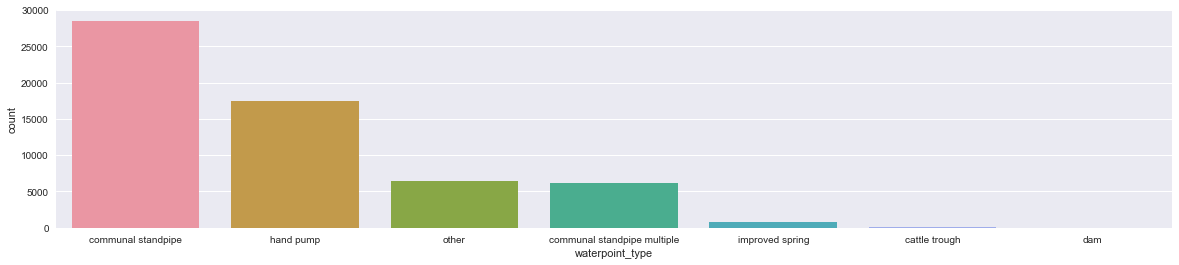

***** 'water_quality' feature distribution breakdown *****


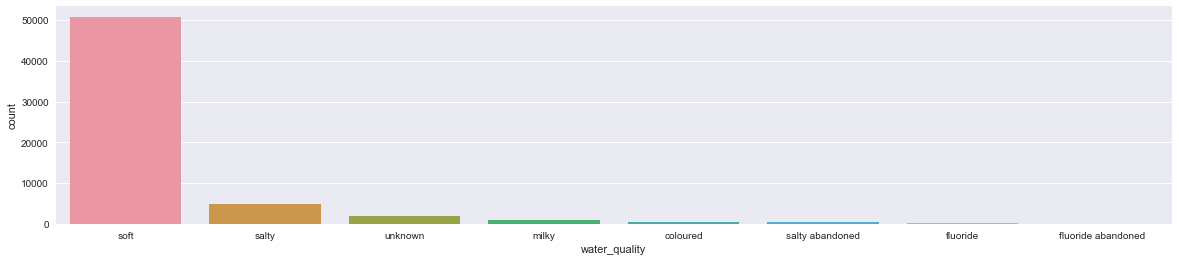

***** 'source_type' feature distribution breakdown *****


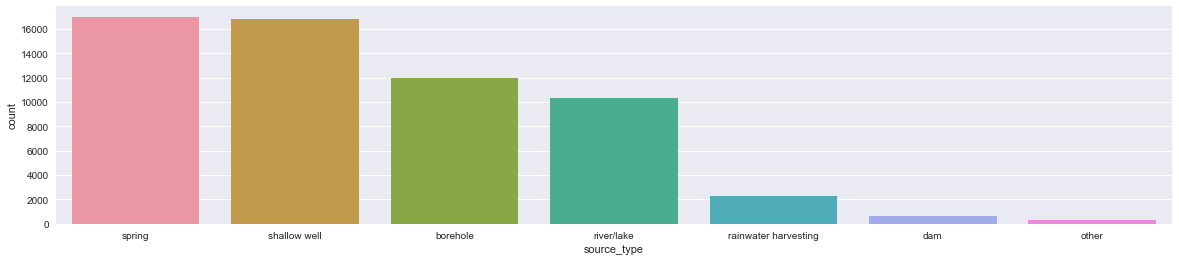

***** 'region' feature distribution breakdown *****


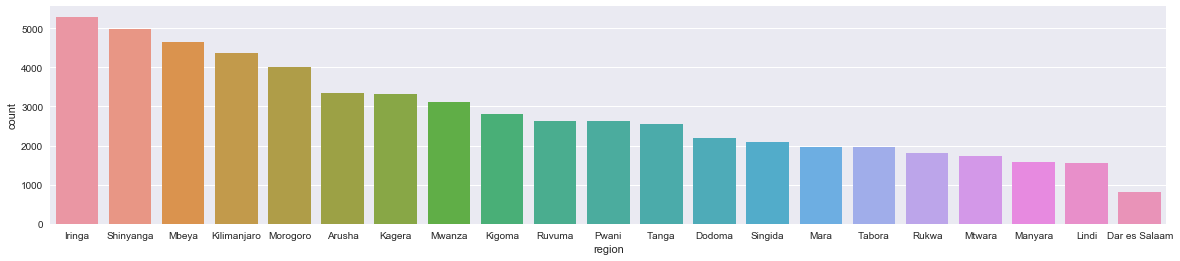

***** 'management_group' feature distribution breakdown *****


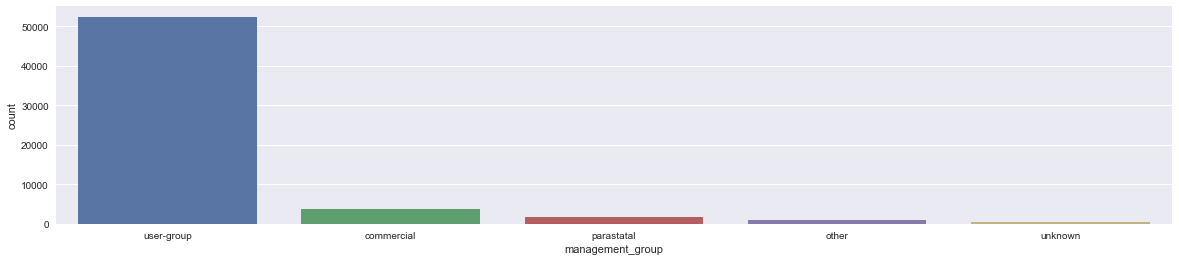

In [118]:
# Categorical features of interest
sample_categorical_features = ['waterpoint_type', 'water_quality', 'source_type','region', 'management_group']
for i in sample_categorical_features:
    print("***** \'{}\' feature distribution breakdown *****".format(i))
    #print(categorical_features_df[i].value_counts())
    sns.set(style='darkgrid')
    fig = plt.figure(figsize = (20,4))
    sns.countplot(x=i,data=categorical_features_df, order = categorical_features_df[i].value_counts().index)
    plt.show()

In [125]:
#let's check the categorical features
numerical_features_df = train_features_df.select_dtypes(include=['int64','float64']).copy()
numerical_features_df.head()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999
1,8776,0.0,1399,34.698766,-2.147466,0,20,2,280,2010
2,34310,25.0,686,37.460664,-3.821329,0,21,4,250,2009
3,67743,0.0,263,38.486161,-11.155298,0,90,63,58,1986
4,19728,0.0,0,31.130847,-1.825359,0,18,1,0,0


A couple of observations:
* most of the numerical features are ordinals (codes) or location infromation
* the only numerical value is amount_tsh: the total static head (amount water available to waterpoint) 
* we can derive another feature - the age of the pump - from the consruction year

In [129]:
# Store the list of numerical features
numerical_cols = numerical_features_df.columns.tolist()

Let's look at the static head numerical info feature (source: www.pumpsandsystems.com):
![static head](https://www.pumpsandsystems.com/sites/default/files/Rockwell_20Fig2.jpg)

In [132]:
# total static head stats profile
numerical_features_df['amount_tsh'].describe()

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

Wow, there are huge variations in this numerical feature. Let's box plot it. 

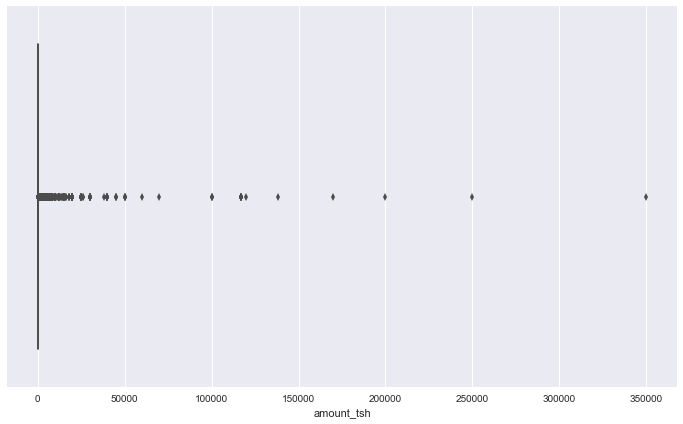

In [144]:
plt.figure(figsize=(12, 7))
sns.boxplot(x=numerical_features_df['amount_tsh'])

There seems to be significant outliers in this numerical features, we will need to deal with these as well before modelling  

### Exploration of labels¶
The labels that we will use to train our modelon represent the status of the water pumps

In [145]:
# Explore the features of the train label set 
train_label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
id              59400 non-null int64
status_group    59400 non-null object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


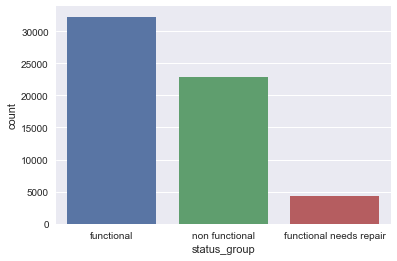

In [146]:
# There are three water pumps possible labels
#train_label_df['status_group'].value_counts()
sns.countplot(x='status_group',data=train_label_df)

We observe that one of the classes is imbalanced - functional needs repair is under represented.


## Missing or Duplicate Data Observations

Use seaborn to create a simple heatmap to see where we are missing data!

### Check the feature test data set

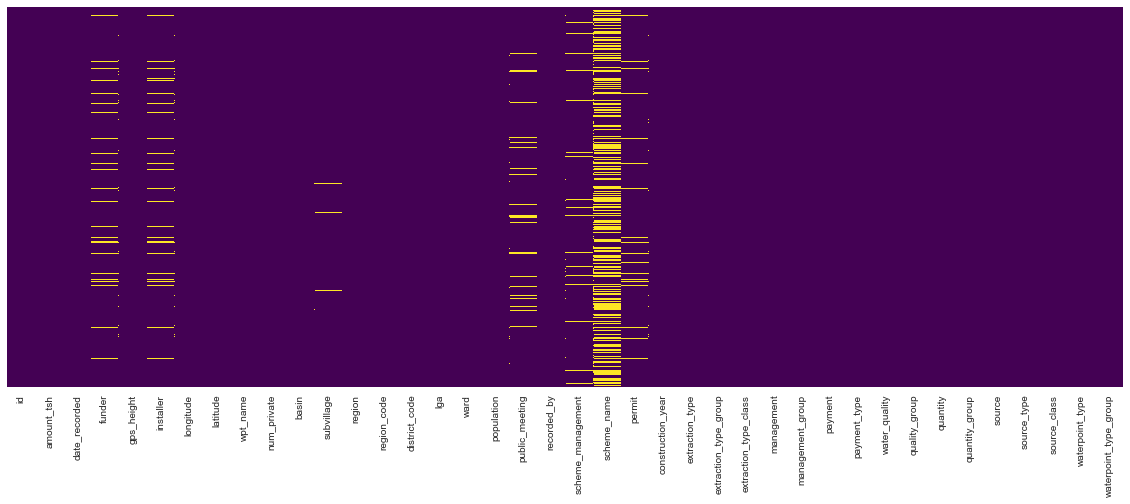

In [166]:
# get an overview of the missing training data fields (NaN) in yellow
plt.figure(figsize=(20, 7))
sns.heatmap(train_features_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

There are definitelysome missing values in this data sets
Let look in more detail at how mainy NaN we have for each feature

In [154]:
# compute number of Nan values for the data set
num_null_val = train_features_df.isnull().sum().sort_values(ascending=False).head(20)
num_null_val

scheme_name              28166
scheme_management         3877
installer                 3655
funder                    3635
public_meeting            3334
permit                    3056
subvillage                 371
ward                         0
lga                          0
district_code                0
region_code                  0
region                       0
waterpoint_type_group        0
population                   0
num_private                  0
wpt_name                     0
latitude                     0
longitude                    0
gps_height                   0
date_recorded                0
dtype: int64

About half the scheme_name feature's values are missing - we might consider dropping this feature. Other features have some missing values but we should be able to impute these missing values 

In [169]:
# now check for duplicates
train_features_df.duplicated().sum()

0

No duplicates in the training data set

### Check the feature label and test data sets

Let's check the labels and the test data sets for missing values

In [164]:
#train_label_df
num_null_val = train_label_df.isnull().sum().sort_values(ascending=False).head(20)
num_null_val
#train_features_df.duplicated().sum()

status_group    0
id              0
dtype: int64

In [170]:
# now check for duplicates
train_label_df.duplicated().sum()

0

No missing or duplicate values for the label data set

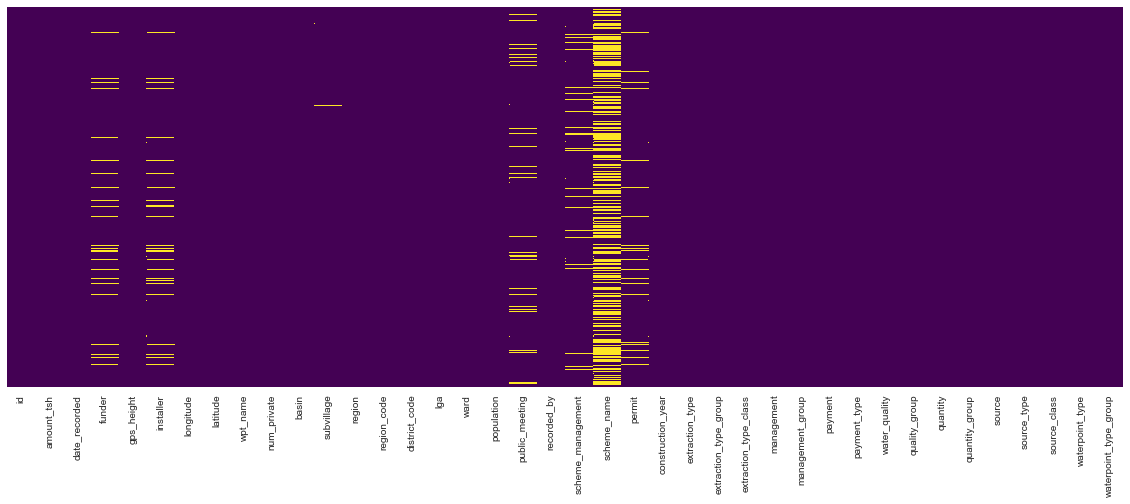

In [167]:
# get an overview of the missing test data fields (NaN) in yellow
plt.figure(figsize=(20, 7))
sns.heatmap(test_features_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [168]:
#test_features_df
num_null_val = test_features_df.isnull().sum().sort_values(ascending=False).head(20)
num_null_val

scheme_name              7092
scheme_management         969
installer                 877
funder                    869
public_meeting            821
permit                    737
subvillage                 99
ward                        0
lga                         0
district_code               0
region_code                 0
region                      0
waterpoint_type_group       0
population                  0
num_private                 0
wpt_name                    0
latitude                    0
longitude                   0
gps_height                  0
date_recorded               0
dtype: int64

Similar to the test data set, many scheme_name feature's values are missing. Other features have some missing values as well

In [173]:
# now check for duplicates
test_features_df.duplicated().sum()

0

No duplicates in the test data set

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


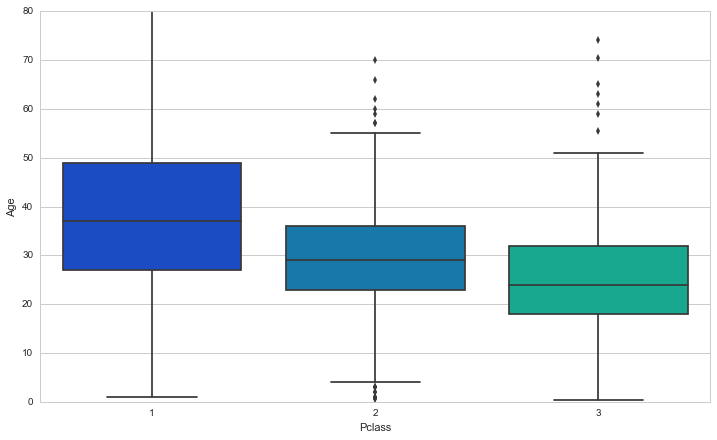

In [86]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [87]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Now apply that function!

In [88]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

Now let's check that heat map again!

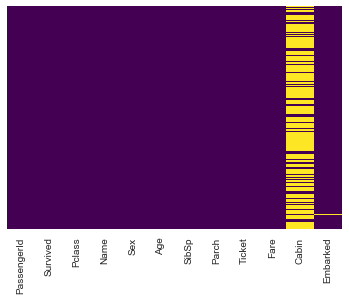

In [89]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [90]:
train.drop('Cabin',axis=1,inplace=True)

In [91]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [92]:
train.dropna(inplace=True)

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [93]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [94]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [95]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [96]:
train = pd.concat([train,sex,embark],axis=1)

In [97]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1.0,0.0,1.0
1,2,1,1,38.0,1,0,71.2833,0.0,0.0,0.0
2,3,1,3,26.0,0,0,7.9250,0.0,0.0,1.0
3,4,1,1,35.0,1,0,53.1000,0.0,0.0,1.0
4,5,0,3,35.0,0,0,8.0500,1.0,0.0,1.0


Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [98]:
from sklearn.model_selection import train_test_split

In [100]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [101]:
from sklearn.linear_model import LogisticRegression

In [102]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [103]:
predictions = logmodel.predict(X_test)

Let's move on to evaluate our model!

## Evaluation

We can check precision,recall,f1-score using classification report!

In [104]:
from sklearn.metrics import classification_report

In [105]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.81      0.93      0.86       163
          1       0.85      0.65      0.74       104

avg / total       0.82      0.82      0.81       267



Not so bad! You might want to explore other feature engineering and the other titanic_text.csv file, some suggestions for feature engineering:

* Try grabbing the Title (Dr.,Mr.,Mrs,etc..) from the name as a feature
* Maybe the Cabin letter could be a feature
* Is there any info you can get from the ticket?

## Great Job!